In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:

# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen_futures.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


#Return Forecasting: Initial Time-Series Plotting
##Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?



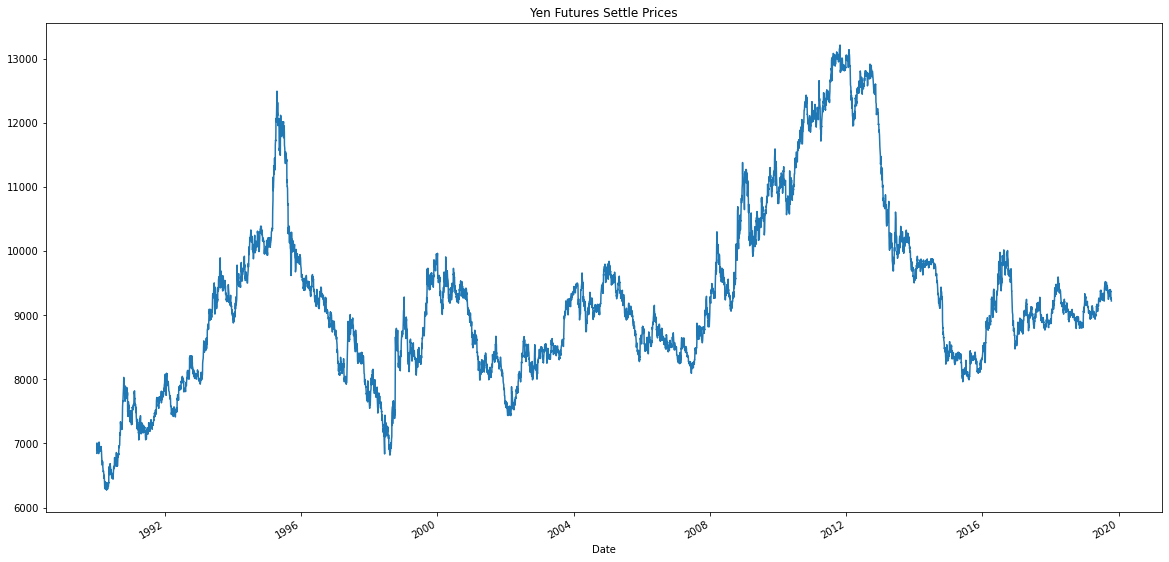

In [5]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot(title='Yen Futures Settle Prices',figsize=(20,10))

### Based on the graph, the Japanese Yen value has strengthened over time in comparison to the US Dollar. There are several short up and downs.  

# Hodrick - Prescott Filter

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])


In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_hp_data = yen_futures['Settle'].to_frame()
yen_hp_data['noise'] = yen_noise
yen_hp_data['trend'] = yen_trend
yen_hp_data.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


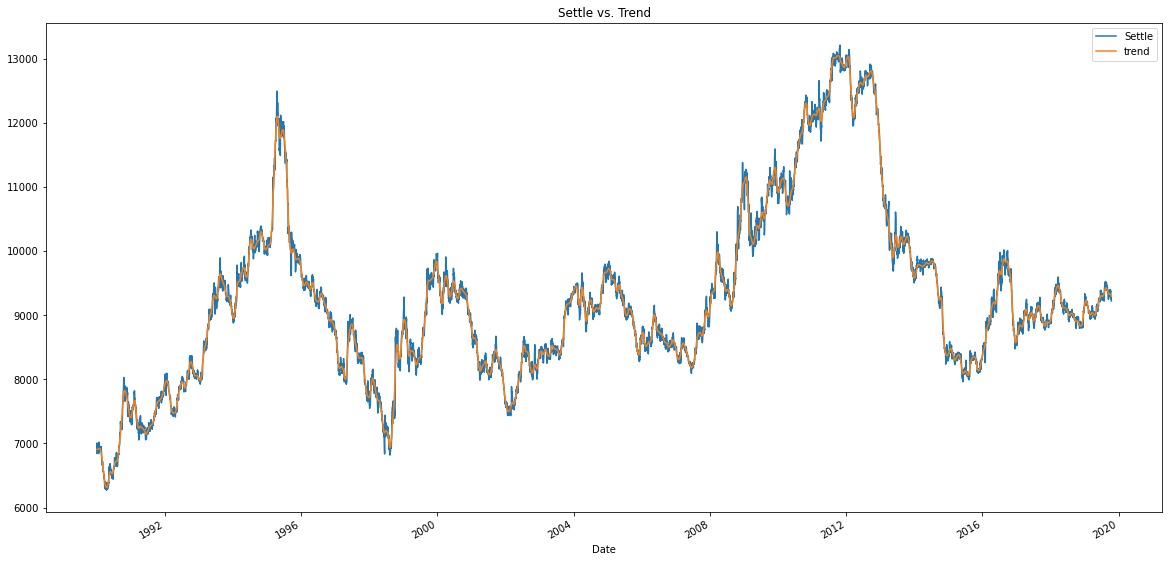

In [8]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_hp_data.plot(y=['Settle', 'trend'], figsize=(20,10), title='Settle vs. Trend')

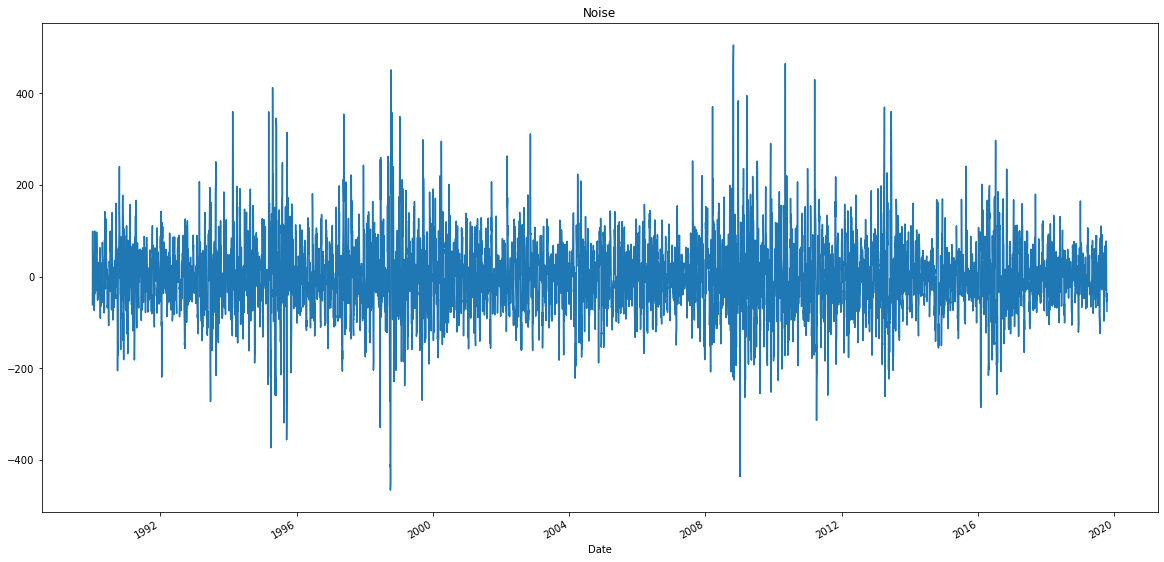

In [9]:

# Plot the Settle Noise
yen_hp_data['noise'].plot(figsize=(20,10),title='Noise')

# Forecasting Returns using an ARMA Model

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [11]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, orders=(1,1))

# Fit the model and assign it to a variable called results
results = model.fit()

TypeError: __init__() got an unexpected keyword argument 'orders'

In [12]:
# Output model summary results:
results.summary()

NameError: name 'results' is not defined

In [ ]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")


# Forecasting the Settle Price using an ARIMA Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures["Settle"].values, order=(5,1,1))

# Fit the model
results =model.fit()

In [ ]:
# Output model summary results:
results.summary()

In [ ]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Futures Price Forecast')

# Volatility Forecasting with GARCH

In [ ]:
import arch as arch
from arch import arch_model

In [ ]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
results = model.fit(disp="off")

In [ ]:
# Summarize the model results
results.summary()

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()


In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot(title='5 Day Volatility Forecast')